<img src='https://pennstatelaw.psu.edu/sites/default/files/styles/content_header_image/public/M%20and%20A%20center%201.jpg?itok=nxlHzngRhttps://pennstatelaw.psu.edu/sites/default/files/styles/content_header_image/public/M%20and%20A%20center%201.jpg?itok=nxlHzngR' height="100%" width="3500">

# <font color=blue|blue|red>**EVA - Estratégia de Investimento**</font> 

Environmental Value Algorithm (EVA) é uma <ins>**_estratégia de investimento baseda na hipótese de que empresas que são economicamente sustetáveis possuem ações com alto potencial de crescimento no médio e longo prazo_**</ins>. Nesse sentido o EVA seleciona as empresas e ações por meio de 2 filtros. Primeiro as empresas economicamente sustetáveis vão ser aquelas que compoem o Indíce de Sustentabilide Economica (ISE) da B3 em determinado periodo, bem como as suas respectivas ações. Segundo, para encontrar dentro do ISE quais são as ações com maior potencial de crescimento, o algoritimo usa  o Piotroski F-Score, que por meio da avaliação de 9 critérios, que usam indicadores financeiros, levam a uma pontuação que varia de 0 a 9.

### <font color=green|black>**Resumo Resultados:** </font>
Os parâmetros ótimos para essa estratégia são F-Score mínimo de 5, alocação por GMV considerando 6 períodos anterirores. O EVA obteve medianos para ruins, uma vez qu8e sua volatilidade é muito alta se comprada ao seu retorno, ou seja, um sharpe menor do que 1. Além de que, o número de ativos alocados em cada período pode ser muito baixo chegando a um único ativo, indicando uma diverssificação baixisíma. Fora que a estratégia possui drawdowns muito extansos, tendo um específico de mais de dois anos. Ademais o retorno dp EVA está concentrado em poucos acertos quwe geram muito retorno, o que indica uma inconsistência nos retornos, além desses acertos estarem muito distantes um dos outros.  

Estratégia | Retorno Total | Retorno a.a | Vol a.a. | Sharpe | Drawdown |
---|---|---|---|---|---|
EVA | 185.02% | 14.99%| 22.86% | 0.58 | 26% |

### <font color=green|black>**Perído Análisado:** </font>
O Período análisado foi de 2017-07 até 2019-12. Por que os dados mais antigos a respeito dos indicadore que obetivemos foi de um trimestre antes, e para calcular o F-Score é necessário a variação, assimexclui-se o primeiro semestrre da análise

### <font color=green|black>**Base de Dados:** </font>
**Carteiras ISE**. A fonte usada para criar a base de dados da carteira do ISE foi o prórpprio site da B3:
> http://www.b3.com.br/data/files/FB/23/66/F3/013257102C784E47AC094EA8/Evolutivo%20das%20Carteiras%20ISE%202020.pdf

**Preços Ações**. A fonte usada foi a API Alpha Vantage. A coleta foi feita por meio do pandas DataReader. O problema dessa base de dados é que ela sofre com o viés da sobrevivência, ou seja, algumas ações que não existem mais atualmente, por causa de falência, fusão, aquisição, saída da B3, não estão presente nessa base de dados, e são elas:
> []

**Indicadores**. A fonte usada foi a Capiatl IQ, que os alunos da USP tem acessos de forma gratuíta. Inicialmente coletou-se os balanços. DRE, e DFC das empresas, e após isso calculou-se os indicadores necessários para o calculo do F-Score. Essa base de dados tem o mesmo problema da base de preços o viés da sobrevivência e são elas:
> ['TIET', 'FIBR', 'ELPL', 'CLSC', 'DTEX', 'LIGT', 'CPLE','CESP', 'EVEN', 'COCE', 'CSMG', 'AEDU', 'JSLG']

### <font color=green|black>**Bibliotecas:** </font>

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import edhec_risk_kit as erk
from scipy.optimize import minimize

# <font color=blue|blue|red>**Backtest - EVA**</font> 

In [2]:
# Data inicio backtest
dt_ini = '2012-07'
# Tx livre de risco (CDI - 2020)
tx_livre = 0.019

## <font color=green|black>**1. Importar Precos E Retornos Ações:** </font>
Nesse primeira etapa vamos importar todas as bases de dados necessárias para o backtest dessa estratégia. Bem como o tratemente se necessário dessas informações, seja para por alguma facilitade ou para criar novos dados.

#### Importa Preço Ações ISE 2010-2019

In [3]:
# importa csv
df_precos = pd.read_csv("data/precos20102019.csv", index_col=0)
df_precos.head()

,OIBR4.SA,TIET3.SA,LAME4.SA,LAME3.SA,SANB4.SA,COCE3.SA,SANB11.SA,ROMI3.SA,OIBR3.SA,BRKM3.SA,...,CLSC4.SA,VIVT3.SA,CESP3.SA,NTCO3.SA,LIGT3.SA,MRVE3.SA,GGBR3.SA,TIET11.SA,SULA3.SA,GOAU3.SA
2009-11,19.3766,0.0548,6.9548,5.0920,7.6633,17.2540,13.6649,6.4875,264.2783,6.2884,...,NaN,15.3220,9.6200,33.5364,13.8455,7.6727,16.4413,NaN,NaN,24.3117
2009-12,19.1029,0.0529,7.4487,5.6232,8.0290,17.2592,14.1381,6.0267,259.5607,7.1506,...,NaN,15.2656,10.0880,36.2952,14.9318,8.5296,17.9165,NaN,NaN,24.6466
2010-01,14.9289,0.0529,6.3452,5.0611,7.6638,17.5248,13.3214,7.2444,191.2504,7.1738,...,NaN,14.9883,10.3219,33.9262,14.3283,7.3499,15.7660,NaN,NaN,23.1352
2010-02,14.1644,0.0539,6.2351,4.7887,7.2989,17.5248,12.6530,6.9361,186.6271,7.1506,...,NaN,14.2166,9.8280,33.2865,15.3170,7.9248,16.2190,NaN,NaN,24.2278
2010-03,13.0010,0.0537,6.3656,4.8610,7.6638,17.7903,13.0649,6.4824,148.7921,6.7253,...,NaN,13.2295,10.2335,36.0853,15.0128,7.5074,17.7873,NaN,NaN,24.5645


In [4]:
# Arruma coluna nomes
df_precos.columns = [x[:-3] for x in df_precos.columns]
# Transforma o index em periodo
df_precos.index = pd.to_datetime(df_precos.index, format='%Y-%m').to_period('M')
df_precos['2019'].head()

,OIBR4,TIET3,LAME4,LAME3,SANB4,COCE3,SANB11,ROMI3,OIBR3,BRKM3,...,CLSC4,VIVT3,CESP3,NTCO3,LIGT3,MRVE3,GGBR3,TIET11,SULA3,GOAU3
2019-01,1.34,2.0825,20.8455,15.3456,21.5404,40.7353,44.5230,6.5772,1.30,46.7793,...,51.5198,36.0028,19.2162,47.4107,19.7580,13.2102,12.3768,9.5667,14.3688,7.4871
2019-02,1.80,2.0651,19.6979,14.7082,20.5160,39.8301,41.6237,7.1693,1.79,48.7789,...,51.3324,37.3269,19.6837,48.3603,19.6688,11.9684,12.1625,9.5583,12.4947,7.2531
2019-03,1.51,1.9688,16.5914,12.9629,20.0268,40.7353,40.7255,7.2087,1.52,47.9918,...,50.0491,38.4263,20.0524,45.3715,20.3624,12.3207,11.9863,9.0986,11.5124,7.0378
2019-04,1.68,1.9247,15.5525,12.5510,21.5343,42.3951,41.9390,6.2244,1.69,46.6153,...,44.0260,37.6177,22.4029,52.2188,21.1900,12.7787,11.4165,9.2016,11.7927,6.7825
2019-05,1.60,2.0798,15.9680,12.6491,20.5593,41.3015,42.5821,7.2975,1.47,38.9435,...,50.1084,38.8717,23.5697,59.9556,18.9400,15.1477,11.4075,10.0733,11.4156,6.5083


#### Cria DataFrame de Retorno das Ações

In [5]:
# retornos mensal 
rets = df_precos.pct_change().iloc[1:]
rets.head()

,OIBR4,TIET3,LAME4,LAME3,SANB4,COCE3,SANB11,ROMI3,OIBR3,BRKM3,...,CLSC4,VIVT3,CESP3,NTCO3,LIGT3,MRVE3,GGBR3,TIET11,SULA3,GOAU3
2009-12,-0.014125,-0.034672,0.071016,0.104321,0.047721,0.000301,0.034629,-0.071029,-0.017851,0.137110,...,NaN,-0.003681,0.048649,0.082263,0.078459,0.111682,0.089725,NaN,NaN,0.013775
2010-01,-0.218501,0.000000,-0.148147,-0.099961,-0.045485,0.015389,-0.057766,0.202051,-0.263177,0.003244,...,NaN,-0.018165,0.023186,-0.065270,-0.040417,-0.138307,-0.120029,NaN,NaN,-0.061323
2010-02,-0.051209,0.018904,-0.017352,-0.053822,-0.047613,0.000000,-0.050175,-0.042557,-0.024174,-0.003234,...,NaN,-0.051487,-0.047850,-0.018856,0.069003,0.078219,0.028733,NaN,NaN,0.047227
2010-03,-0.082135,-0.003711,0.020930,0.015098,0.049994,0.015150,0.032554,-0.065411,-0.202730,-0.059478,...,NaN,-0.069433,0.041260,0.084082,-0.019860,-0.052670,0.096695,NaN,NaN,0.013897
2010-04,-0.021052,-0.001862,-0.024208,0.009072,-0.095227,-0.044766,-0.086001,-0.020810,-0.088776,-0.061529,...,NaN,-0.017446,-0.014218,0.022161,-0.023673,-0.008858,-0.014077,NaN,NaN,-0.013373


#### Importa Composição Carteira ISE
Nesse DataFrame cada linha contêm os tickers das ações que compunham o ISE em determinado ano

In [6]:
# importa csv
comp_ise = pd.read_csv("data/composicao_ise.csv", index_col=0, sep=';')
# transforma index em periodo
comp_ise.index = pd.to_datetime(comp_ise.index, format='%Y').to_period('Y')
# strip nos ticker, pois podem conter espacos
comp_ise[comp_ise.columns] = comp_ise.apply(lambda x: x.str.strip())

comp_ise.head()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
2009,ELPL3.SA,ELPL4.SA,TIET4.SA,TIET4.SA,TIET11.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BRKM3.SA,BRKM5.SA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,ELPL3.SA,ELPL4.SA,TIET4.SA,TIET4.SA,TIET11.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BRKM3.SA,BRKM5.SA,...,USIM6.SA,VIVT3.SA,VIVT4.SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,ELPL3.SA,ELPL4.SA,TIET4.SA,TIET4.SA,TIET11.SA,AEDU3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BRKM3.SA,...,TIMP3.SA,EGIE3.SA,UGPA3.SA,VALE3.SA,VIVT3.SA,VIVT4.SA,NaN,NaN,NaN,NaN
2012,ELPL3.SA,ELPL4.SA,TIET4.SA,TIET4.SA,TIET11.SA,AEDU3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BRKM3.SA,...,SUZB3.SA,TIMP3.SA,EGIE3.SA,UGPA3.SA,VALE3.SA,NaN,NaN,NaN,NaN,NaN
2013,ELPL3.SA,ELPL4.SA,TIET4.SA,TIET4.SA,TIET11.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BRKM3.SA,BRKM5.SA,...,VIVT4.SA,TIMP3.SA,EGIE3.SA,UGPA3.SA,VALE3.SA,WEGE3.SA,NaN,NaN,NaN,NaN


#### Indicadores financeiros
Os indicadores de cada ticker estão armazenados em um arquivo HDF, devido a alta velocidade de extração.

In [7]:
# Importa HDF 
indicadores = pd.HDFStore('data/fundamentos_limpo/indicadores.h5')
indicadores['ABEV'].head()

,roa,fco,lc,alavancagem,shares,ga,margem_bruta
2012-03-31,0,1647.82,1,1,9809.09,0,0.181377
2012-06-30,2.29353e+45,2599.62,1,1,9556.38,1.36508e+46,0.168014
2012-09-30,1.5144e+45,3634.67,1,1,9464.99,8.03602e+45,0.188451
2012-12-31,0.0731821,6993.47,1.05015,0.632117,249.061,0.327783,0.223264
2013-03-31,0.0466515,935.942,1,1,9693.6,0.253328,0.184155


#### Benchmarks
Importamos IBOV, CDI, IBX e S&P, para usarmos como becnhmarking

In [8]:
def retorno_mensal(benchmark: pd.DataFrame, pl_inicial=1000, nome='Wealth', dt_inicio='2012-07'):
    """
    Dada um DataFrame de valores dos benchmark,
    devolve a evolucao mensal do patrimonio caso alocasse no indice
    :benchmark: DataFrame com os valores diarios do benchmark
    :pl_inicial (opcional): patrimonio inicial
    :nome (opcional): nome da coluna do DataFrame
    :dt_inicio (opcional): data de inicio da alocacao
    
    return Dataframe 
    """
    benchmark['M'] = benchmark.index.to_period('M')
    return (pl_inicial*(1+benchmark.groupby('M').last().pct_change().iloc[1:][dt_inicio:]).cumprod()).rename(columns={benchmark.columns[0]:nome})
    

In [9]:
# Importar Indices
# ibov
ibov = pd.read_csv('data/ibov.csv', index_col=0)
ibov.index = pd.to_datetime(ibov.index, format='%Y-%m-%d')
# Obtemos evolucao mensal
ibov_m = retorno_mensal(ibov, nome='pl_IBOV')

# ibx
ibx = pd.read_csv('data/ibx.csv', index_col=0)
# Obtemos evolucao mensal
ibx.index = pd.to_datetime(ibx.index, format='%Y-%m-%d')
ibx_m = retorno_mensal(ibx, nome='pl_IBX')

# s&p
sp = pd.read_csv('data/s&p.csv', index_col=0)
# Obtemos evolucao mensal
sp.index = pd.to_datetime(sp.index, format='%Y-%m-%d')
sp_m = retorno_mensal(sp, nome='pl_S&P')

# cdi
cdi = pd.read_csv('data/cdi.csv', index_col=0)
# Obtemos evolucao mensal
cdi.index = pd.to_datetime(cdi.index, format='%Y-%m-%d')
cdi_m = retorno_mensal(cdi, nome='pl_CDI')

cdi_m.head()

,pl_CDI
M,
2012-07,1006.774446
2012-08,1013.703571
2012-09,1019.149804
2012-10,1025.349180
2012-11,1030.933332


## <font color=green|black>**2. Estratégia:** </font>
Nessa etapa vamos implementar o Piotroski F-Score. Para isso temos que fazer as seguintes tarefas.
- Calcular o F-Score de cada trimestre das empresas
- Selecionar X ações com base em um Score mínimo

In [10]:
def calcula_piotroski(indicadores: pd.HDFStore, score=1):
    """
    Dado um DataFrame de indicadores financeiros, retorna as o f scores das empresas,
    :indicadores: pd.HDFStore com os indicadores de cada empresa
    :score (opcional): valor a ser dado por cada score 
    
    return DataFrame com os f score de cada empresa por periodo
    """
    # list sem margem_bruta
    sem_mb = ['/TIMP', '/UGPA', '/USIM', '/VALE', '/VIVT','/VVAR','/WEGE', '/YDUQ']
    
    # Verifica se indicadores é um HDFStore
    if isinstance(indicadores, pd.HDFStore) and (isinstance(score, int) or isinstance(score, float)):
        # lista de DataFrames
        dfs = []
        
        # Nome empresas
        keys = indicadores.keys()
        keys.remove('/TOTS')
        
        # Loop por cada empresa (key)
        for key in keys:
            # qtde de linhas
            l = len(indicadores[key])
            
            # F-Score total por periodo
            tt_score = np.zeros((l - 1,1)).reshape(l - 1, 1)

            # ROA corrente positivo, score +1
            tt_score += indicadores[key]['roa'].apply(lambda x: score if x > 0 else 0).to_numpy()[1:].reshape(l - 1, 1)

            # FCO positivo, score +1
            tt_score += indicadores[key]['fco'].apply(lambda x: score if x > 0 else 0).to_numpy()[1:].reshape(l - 1, 1)

            # ROA corrente maior que ROA passado, score +1
            tt_score += indicadores[key]['roa'].pct_change().apply(lambda x: score if x > 0 else 0).to_numpy()[1:].reshape(l - 1, 1)

            #Alavancagem Passado maior que Alavancagem presente, score +1
            tt_score += indicadores[key]['alavancagem'].pct_change().apply(lambda x: score if x > 0 else 0)[1:].to_numpy().reshape(l - 1, 1)

            #Liquidez Corrente maior que Liquidez passada, score +1
            tt_score += indicadores[key]['lc'].pct_change().apply(lambda x: score if x > 0 else 0).to_numpy()[1:].reshape(l - 1, 1)

            #Quantidade de Ações permaneceu igual, score +1
            tt_score += indicadores[key]['shares'].pct_change().apply(lambda x: score if x == 0 else 0)[1:].to_numpy().reshape(l - 1, 1)

            #Margem Bruta corrente maior que Margem Bruta passada, score +1
            if key not in sem_mb:
                tt_score += indicadores[key]['margem_bruta'].pct_change().apply(lambda x: score if x == 0 else 0)[1:].to_numpy().reshape(l - 1, 1)

            #Giro de Ativo Corrente maior que Giro de Ativo Passado, score +1
            tt_score += indicadores[key]['ga'].pct_change().apply(lambda x: score if x == 0 else 0).to_numpy()[1:].reshape(l - 1, 1)
            
            # Cria o DataFrame
            ## index
            index = (pd.to_datetime(indicadores[key].index, format='%Y-%m-%d') + pd.DateOffset(1)).to_period('3M')[1:]
            dfs.append(pd.DataFrame(tt_score, index=index, columns=[key[1:]]))
            
        # Return DataFrames
        return reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), dfs)
    
    else:
        raise TypeError("Expected 'indicadores' to be pd.HDFStore and 'score' an int or float")

In [11]:
# calcula F-Score de cada trimestre
piotroski = calcula_piotroski(indicadores)
piotroski.head()

,ABEV,AZUL,B3SA,BBAS,BBDC,BBSE,BEEF,BPAC,BRAP,BRDT,...,SUZB,TAEE,TIMP,UGPA,USIM,VALE,VIVT,VVAR,WEGE,YDUQ
2012-07,3.0,NaN,5.0,3.0,5.0,NaN,3.0,4.0,4.0,NaN,...,2.0,4.0,4.0,4.0,4.0,2.0,3.0,1.0,3.0,2.0
2012-10,2.0,NaN,3.0,3.0,3.0,NaN,3.0,3.0,4.0,NaN,...,2.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0
2013-01,3.0,NaN,2.0,4.0,3.0,NaN,3.0,3.0,2.0,NaN,...,3.0,4.0,5.0,4.0,2.0,3.0,5.0,3.0,4.0,2.0
2013-01,3.0,NaN,2.0,4.0,3.0,NaN,3.0,3.0,2.0,NaN,...,3.0,4.0,5.0,4.0,2.0,3.0,5.0,3.0,4.0,2.0
2013-04,3.0,3.0,4.0,3.0,5.0,NaN,2.0,4.0,4.0,NaN,...,3.0,6.0,3.0,2.0,1.0,4.0,4.0,4.0,4.0,5.0


In [12]:
def x_melhores_piotroski(rets: pd.DataFrame, piotroski: pd.DataFrame, comp_ise: pd.DataFrame, minimum_score=4):
    """
    Dado um DataFrame de F-Score, retorna as Y acoes que compunham a carteira do ISE no periodo,
    e tenham o f score piotroski maior que o 'minimum_score'
    :piotroski: DataFrame com os F-Scores das empresas
    :rets: DataFrame com retorno mensal das acoes
    :comp_ise: DataFrame com as acoe sque compunham a carteira do ISE em cada ano
    :minimum_score: valor para filtrar as empresas selecionadas 
    
    return um Dict com as acoes selecionadas de cada periodo
    """
    # acoes q n possuem infromacoes financeiras
    l_exclui = ['TIET', 'FIBR', 'ELPL', 'CLSC', 'DTEX', 'LIGT', 'CPLE','CESP', 'EVEN', 'COCE', 'CSMG', 'AEDU', 'JSLG']
    # Verifica se piotroski é um DataFrame
    if isinstance(piotroski, pd.DataFrame) and isinstance(comp_ise, pd.DataFrame) and isinstance(minimum_score, int):
        # Dict com os tickers das acoes escolhidas
        dict_melhores = {}
        # periodos
        periodos = rets.index.to_series().astype(str)
        # Loop por periodo de retorno
        for p in periodos:
            # Seleciona os tickers das acoes que compoem o ISE no periodo 'p'
            tickers = [x[:4] for x in comp_ise[p[:4]].iloc[0].dropna().to_numpy()]
            # remove as acoes que n posseum informacoes dos indicadores
            tickers = [e for e in tickers if e not in l_exclui]
            # filtra as acoes com base no score minimo
            ## Tickers sem numeracao
            melhores_sem = list(piotroski[:p][tickers].iloc[-1][piotroski[:p][tickers].iloc[-1] >= minimum_score].index)
            ## Add numero nos tickers 
            melhores = []
            for t in rets.columns:
                melhores += [t for x in melhores_sem if x in t]
            dict_melhores[p] = list(set(melhores))
        
        return dict_melhores
    
    else:
        raise TypeError("Expected 'piotroski' to be pd.DataFrame and 'minimum_score' an int")
   

In [13]:
# Escolhemos as X melhores acoes de cada mes
# e armazenamos em um dict
selecionados = x_melhores_piotroski(rets[dt_ini:], piotroski, comp_ise)

## <font color=green|black>**3. Alocação:** </font>
Para a alocação dos ativos vamos usar duas metodologias diferentes e compara-las:
- **EW.** Pesos distribuídos igualmente
- **GMV.** Variância global mínima, ou seja, por meio do Markowitz vamos usar o ponto na fronteira que minimiza o risco (volatilidade). 

#### **Cria Array do EW**

In [14]:
def ew(rets: pd.DataFrame, chosen: dict, tx_livre_risco=False):
    """
    :rets: A Date Frame or a Series that contains the all your possible assets returns
    :chosen: dict of list that contains the ticker of chosen assets
    :tx_livre_risco (True/False): Caso True sera alocado na taxa livre de risco,
        quando em determinado periodo a estrategia nao se posicione em nenhuma acao
    
    Returns a array (periods, number of assets) of weights of an equal weights portfolio
    """
    
    # Verifica tipo variaveis
    if isinstance(rets, pd.DataFrame) is False:
        raise TypeError("Expected 'rets' to be pd.DataFrame")
    elif isinstance(tx_livre_risco, bool) is False:
        raise TypeError("Expected 'tx_livre_risco' to be boolean")
    elif isinstance(chosen, dict) is False:
        raise TypeError("Expected 'chosen' to be pd.DataFrame and 'minimum_score' an int")
    
    # lista de pesos
    pesos = []
#     tickers = [x[:4] for x in rets.columns]
    tickers = rets.columns
        
    # Nao aloca Tx livre
    if tx_livre_risco is False:
        for p in chosen.keys():
            # Tem ativos para alocar
            if len(chosen[p]) > 0:
                # peso
                peso = 1/len(chosen[p])
                pesos.append([peso if x in chosen[p] else 0 for x in tickers])
            # Nao aloca em nada
            else:
                peso = 0
                pesos.append([peso if x in chosen[p] else 0 for x in tickers])

    # Aloca na Tx livre
    elif tx_livre_risco: 
        for p in chosen.keys():
            # Tem ativos para alocar
            if len(chosen[p]) > 0:
                # peso
                peso = 1/len(chosen[p])
                pesos.append([peso if x in chosen[p] else 0 for x in tickers] + [0])
            # aloca Tx livre
            else:
                pesos.append([0]*(rets.shape[1]) + [1])
        
    
    # retorna array de pesos (EW)
    return np.array(pesos)

In [15]:
# Calcula os pesos
p_ew = ew(rets[dt_ini:], selecionados, tx_livre_risco=True)
#Checa se a soma de todos os pesos de cada periodo eh igual a 100% 
len(p_ew) == int(sum([sum(x) for x in p_ew]))

True

#### **Cria Array do GMV**

In [16]:
def portfolio_return(weigths, returns):
    """
    A partir de pesos calcula o retorno do portfolio
    """
    return weigths.T @ returns

def portfolio_vol(weights, covmat):
    """
    A partir de pesos calcula a vol do portfolio
    """
    return (weights.T @ covmat @ weights)**0.5

In [17]:
def msr(risk_free_rate, er, cov):
    """
    Returns the weights of the portfolio tha gives you the maximum sharpe ratio
    given the riskfree ratio and expected returns and a covariance matrix
    """
    n = er.shape[0]
    # Initial weights
    init_guess = np.repeat(1/n, n)
    # Bounds
    bounds = ((0.0, 1.0),)*n
    # Constraints
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe_ratio(weights, risk_free_rate, er, cov):
        """
        Returns the negative of the sarpe ratio, given weigths
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r-risk_free_rate)/vol
        
    results = minimize(neg_sharpe_ratio, init_guess,
                       args=(risk_free_rate, er, cov,), method="SLSQP",
                       options={'disp':False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

In [18]:
def gmv(rets: pd.DataFrame, escolhidos: dict, qtde_periodos: int, index_ini, tx_livre_risco=False):
    """
    Retorna os pesos do portfolio de Variancia Global Minima (GMV), 
    dado os retornos dos ativos
    
    :rets: Um Date Frame que contem todos os retornos dos ativos passiveis de escolha;
    :escolhidos: Um dict de list que contem os tickers/nome das acoes/ativos escolhidos;
    :qtde_periodos: quantidade de periodos usado para calcular o GMV de cada periodo
    :index_ini: index de inicio do backtest
    
    returnm np.array de pesos (GMV)
    """
    
    # Retorna o index_ini com base no iloc
    try:
        index = rets.index.get_loc(index_ini)
    except:
        index = index_ini
    
    # Peridos
    periodos = range(len(rets.iloc[index:]))
    # List de pesos com apenas os ativos escolhidos
    pesos_e = []
    
    # Verifica se existem periodods suficientes para calcular o GMV dfo primeiro periodo
    if len(rets.iloc[:index]) < qtde_periodos and qtde_periodos > 1:
        raise ValueError("'qtde_periodos' deve ser menor ou igual a quantidade de periodos disponiveis antes do index de inicio")
        
    # Calcula os pesos de cada periodo
    for p in escolhidos.keys():
        # matrix de covariancia
        cov = rets.iloc[index - qtde_periodos:index][escolhidos[p]].cov()
        n = cov.shape[0]
        # calcula o gmv do periodo
        pesos_e.append(dict(zip(escolhidos[p], list(msr(0, np.repeat(1,n), cov)))))
        # recalcula o index
        index += 1
    # Cria a matrix de pesos para todo DataFrame de retorno
    pesos = []
    
    # Nao aloca em Tx livre
    if tx_livre_risco == False:
        for p in periodos:
            # Tem ativos para alocar
            if len(escolhidos[list(escolhidos.keys())[p]]) > 0:
                pesos.append([pesos_e[p][x] if x in escolhidos[list(escolhidos.keys())[p]] else 0 for x in rets.columns])
                
            # Nao aloca em nada
            else:
                pesos.append([0 if x in escolhidos[list(escolhidos.keys())[p]] else 0 for x in rets.columns])
    elif tx_livre_risco:
        for p in periodos:
            # Tem ativos para alocar
            if len(escolhidos[list(escolhidos.keys())[p]]) > 0:
                pesos.append([pesos_e[p][x] if x in escolhidos[list(escolhidos.keys())[p]] else 0 for x in rets.columns])
                
            # aloca em Tx livre
            else:
                pesos.append([0 if x in escolhidos[list(escolhidos.keys())[p]] else 0 for x in rets.columns] + [1])
        

    return np.array(pesos)

In [19]:
# Calcula os pesos
p_gmv = gmv(rets, selecionados, 22, dt_ini)
#Checa se a soma de todos os pesos de cada periodo eh igual a 100% 
len(p_gmv) == int(sum([sum(x) for x in p_gmv]))

<ipython-input-16-0c18a3cdb252>:11: RuntimeWarning: invalid value encountered in double_scalars
  return (weights.T @ covmat @ weights)**0.5


True

## <font color=green|black>**4. Backtest (Calculo Retorno):** </font>
Nessa etapa calculamos o retorno da nossa estratéguia usando a alocação, seja ela EW ou GMV

In [20]:
def backtest(rets, allocation, initial_wealth=1000, tx_livre_risco=False):
    """
    :rets: A Date Frame or a Series that contains the assets returns
    :allocation: A Date Frame or a Series  or a Array that contains the assets allocation;
            if its a Date Frame or a Series the index and collumns must be the same of "rets"
    :initial_wealth (optional): The initial budget amount 
    Takes a time series of assets returns and its percentage allocation
    Computes and returns a DataFrame that contains:
    the wealth index
    the portfolio return
    """
    
    # Verifica se deve alocar em Tx livre
    if isinstance(tx_livre_risco, float):
        rets['CDI'] = (1+tx_livre_risco)**(1/12) - 1
    
    # 1. Compute a portfolio return
    if isinstance(allocation, pd.Series) or isinstance(allocation, pd.DataFrame):
        portfolio_rets = (rets*allocation).sum(axis=1)
    elif isinstance(allocation, np.ndarray):
        portfolio_rets = (allocation * rets).sum(axis=1)
    else:
        raise TypeError("Expected allocation to be Series or DataFrame or Array")
        
    # 2. Compute a wealth index
    wealth_index = initial_wealth*(1+portfolio_rets).cumprod()
    # 3. Create a Data Frame
    return pd.DataFrame({
        'Wealth': wealth_index,
        'Returns' : portfolio_rets
    }, index=rets.index)

In [21]:
# Backtest Simples
portfolio_s = backtest(rets[dt_ini:], p_ew, tx_livre_risco=tx_livre)
portfolio_s.head()

<ipython-input-20-b9bc84b1742a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rets['CDI'] = (1+tx_livre_risco)**(1/12) - 1


,Wealth,Returns
2012-07,1020.619767,0.020620
2012-08,995.178226,-0.024928
2012-09,1030.090864,0.035082
2012-10,1037.042369,0.006748
2012-11,1053.048314,0.015434


# <font color=blue|blue|red>**Análise Backtest Estratégia - EVA**</font> 
## <font color=green|black>**1. Analise de Risco x Retorno:** </font>

### **Drawdown**

**Conclusão.** A duração do drawdown máxima foi muito grande, sendo de aproximadamente 2 anos e meio. Além disso o drawdown máximo foi 33.46%. Portanto esses dois pontos já são fortes indicios que nossa estrategia não é boa, especialmente em periodos de baixa do mercado. 

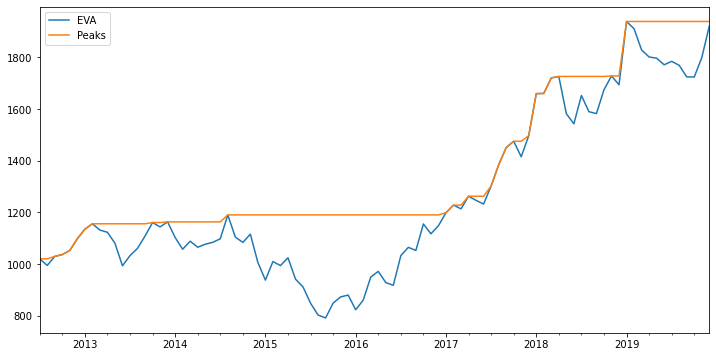

In [22]:
# Calcula e plota drawdown
drawdown = erk.drawdown(portfolio_s['Returns'])
ax_d = drawdown[['Wealth', 'Peaks']].plot(figsize=(12,6))
ax_d.legend(['EVA', 'Peaks'])

Drawdown maximo de 33.46% 



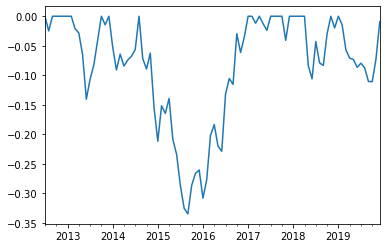

In [23]:
# Calcula Valor Drawdown
drawdown['Drawdown'].plot()
print('Drawdown maximo de {}% \n'.format(round(abs(drawdown['Drawdown'].min() * 100), 2)))

In [24]:
# tempo Maximo drawdown
"""
NNNNNNN SEI FAZER
"""

'\nNNNNNNN SEI FAZER\n'

### **Benchmarking**
**Conclusão.** Nesse primeiro teste da estratégia observamos que tem um resultado abaixo do que todos os benchmkarks, não valendo a pena investir nela, uma vez que a relação retorno risco de qualquer uma delas é melhor que o EVA.

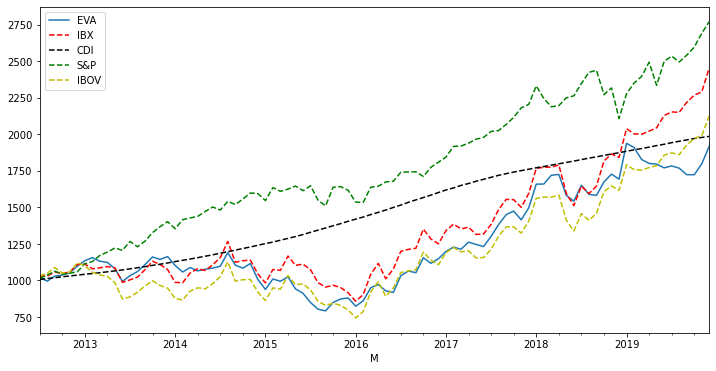

In [25]:
# Plota grafico
ax_b = drawdown['Wealth'].plot(figsize=(12,6), legend=True)
ibx_m.plot(ax=ax_b, style="r--")
cdi_m.plot(ax=ax_b, style="k--")
sp_m.plot(ax=ax_b, style="g--")
ibov_m.plot(ax=ax_b, style="y--")
ax_b.legend(['EVA', 'IBX', 'CDI', 'S&P', 'IBOV'])

In [26]:
# retorno X risco
variacoes = [drawdown['Wealth'], ibx_m, sp_m, ibov_m]
bt_scores = reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), variacoes).copy()
erk.summary_stats(bt_scores.pct_change().iloc[1:], riskfree_rate=tx_livre)[['Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown']]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Wealth,0.088970,0.167799,0.409737,-0.334648
pl_IBX,0.124191,0.186728,0.553583,-0.323007
pl_S&P,0.145262,0.108716,1.141531,-0.135198
pl_IBOV,0.102459,0.197242,0.415753,-0.340720


### **CPPI**

**Conclusão.** Por meio da estratégia de insurance (CPPI) podemos aumentar o sharpe ratio da estratégia a certos níveis de drawdown máximo, como 20%

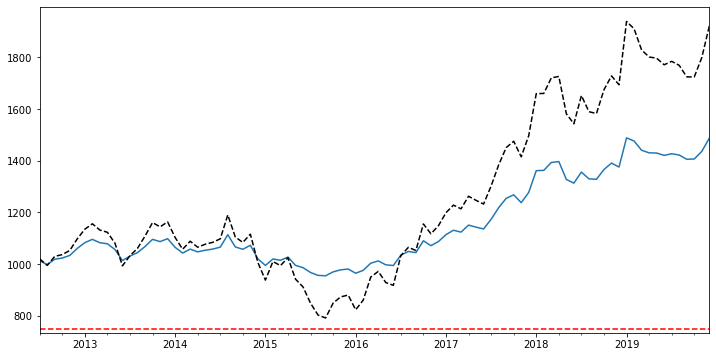

In [27]:
cppi = erk.run_cppi(portfolio_s['Returns'], drawdown = 0.20, riskfree_rate=tx_livre)
ax = cppi['Wealth'].plot(figsize=(12,6), legend=False)
cppi["Risky Wealth"].plot(ax=ax, style="k--", legend=False)
ax.axhline(y=750, color='r', linestyle="--")

In [28]:
# retorno X risco
variacoes = [cppi["Risky Wealth"], cppi['Wealth']]
bt_scores = reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), variacoes).copy()
erk.summary_stats(bt_scores.pct_change().iloc[1:], riskfree_rate=tx_livre)[['Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown']]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Returns_x,0.088970,0.167799,0.409737,-0.334648
Returns_y,0.053117,0.080609,0.415952,-0.142583


### **Retorno**

**Conclusão.** Não se pode inferir muito com apenas o retorno. Porém sabemos que o sharpe da estratégia é menor do que 1, indicando que a estrégia tem um baixo retorno se comprado ao quantidade de risco proporcionada.

In [29]:
# Retorno Total do periodo
r_total_s = ((portfolio_s['Returns']+1).prod()-1)
print('Retorno Total: {}%'.format(round(r_total_s*100, 2)))

# Retorno por periodos
## Anualizado
r_anualizado_s = ((r_total_s + 1) ** (12/len(portfolio_s)) - 1) * 100
print('Retorno Anualizado: {}%'.format(round(r_anualizado_s, 2)))
## Mensal
r_mensal_s = ((r_total_s + 1) ** (1/len(portfolio_s)) - 1) * 100
print('Retorno Mensal: {}%'.format(round(r_mensal_s, 2)))

Retorno Total: 92.04%
Retorno Anualizado: 9.09%
Retorno Mensal: 0.73%


## <font color=green|black>**2. Variando o valor de Piotrosk:** </font>
Nessa etapa vamos variar o valor de F_Score minimo para entender se ela esta influenciando de alguma forma na estratégia, e se conseguimos encontrar um valor ótimo. Nessa situação caso não vamos alocar na taxa livre de risco (CDI) caso não encontyremos nenhuma ação que possua o F-Score mínimo estabelecido. E também vamos manter a alocação pelo método 'EW'.

In [30]:
variacoes = []

# loop nos score min de Piotrosk 
for s in list(range(1,9)):
    melhores = x_melhores_piotroski(rets[dt_ini:], piotroski, comp_ise, minimum_score=s)
    peso_igual = ew(rets, melhores)
    variacoes.append(backtest(rets[dt_ini:], peso_igual)['Wealth'])

In [31]:
# Junta todas as possibilidades
variacoes += [ibx_m, sp_m, ibov_m]
bt_scores = reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), variacoes).copy()
bt_scores.columns = ['f-1', 'f-2', 'f-3', 'f-4', 'f-5', 'f-6', 'f-7', 'f-8', 'IBX', 'S&P','IBOV']
erk.summary_stats(bt_scores.pct_change().iloc[1:], riskfree_rate=tx_livre)[['Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown']]

C:\Nícolas\Programação\Python\finanaças_quantitativas\eva\edhec_risk_kit.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  return ann_ex_ret/ann_vol
C:\Nícolas\Programação\Python\finanaças_quantitativas\eva\edhec_risk_kit.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return exp/sigma_r**3
C:\Nícolas\Programação\Python\finanaças_quantitativas\eva\edhec_risk_kit.py:132: RuntimeWarning: invalid value encountered in double_scalars
  return exp/sigma_r**4


,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
f-1,0.110256,0.156744,0.572145,-0.248590
f-2,0.112123,0.158366,0.577873,-0.247029
f-3,0.114362,0.158515,0.591216,-0.260548
f-4,0.088970,0.167799,0.409737,-0.334648
f-5,0.167564,0.216789,0.673454,-0.243061
f-6,0.104978,0.159195,0.530757,-0.221812
f-7,0.000000,0.000000,-inf,0.000000
f-8,0.000000,0.000000,-inf,0.000000
IBX,0.124191,0.186728,0.553583,-0.323007
S&P,0.145262,0.108716,1.141531,-0.135198


### **Todas as possibilidades**
**Conclusão.** Podemos logo observar que o valor mínimo interfere no risco e retorno da estratégia.

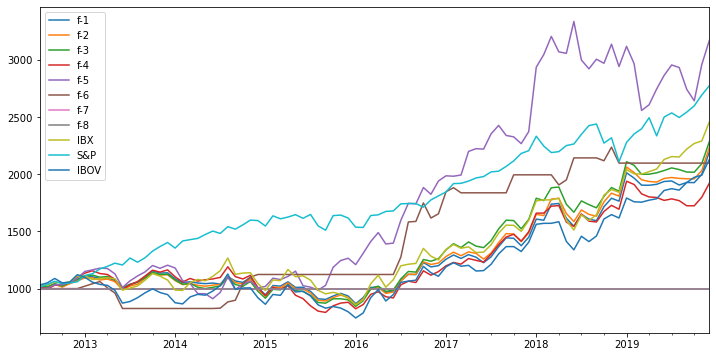

In [32]:
bt_scores.plot(figsize=(12,6))

### **F-1 : F-4**
**Conclusão.** Variando de 1 até 4 a mudança no risco e no retorno do EVA é minima, e a estratégia continua a se comportart muito parecida com o IBOV, mostrando que o impacto do F-Score é mínimo, quase que insignificante.

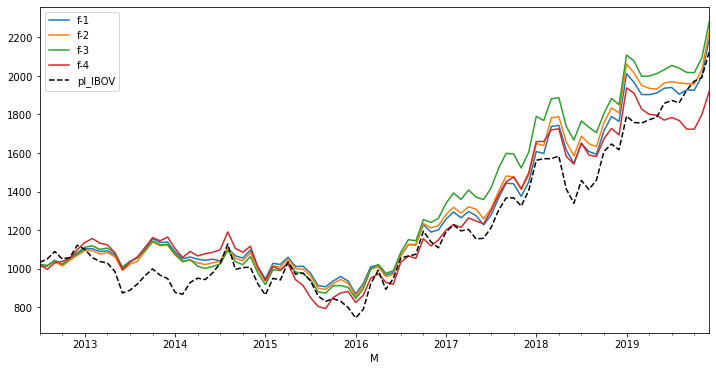

In [33]:
ax = bt_scores[['f-1', 'f-2', 'f-3', 'f-4']].plot(figsize=(12,6))
ibov_m.plot(ax=ax, style="k--")

### **F-5 : F-6**
**Conclusão.** A partir de um F-Score minimo de 5 a influência na estratégia é bem clara. Porém a partir de 6 em alguns periodos não é possíevel alocar em nenhum ativo, uma vez que nenhuma ação atingiu os níveis necessários de Score, por isso vemos grandes periodo de plato no retorno de F-6 (F-Score mínimo de 6). 

**F-5**. Por outro lado o ponto de F-5 é o ponto ótimo, e com ele o EVA bate o IBOV e S&P em questão de retorno (lembrando que o retorno precisa sempre ser analisado junto ao risco). Porém ainda existe um grande problema com a estratégia, sendo ela um grande plato até aproximadamente 2016, sendo assim durante quase 4 anos a estratégia não gera retorno algum.

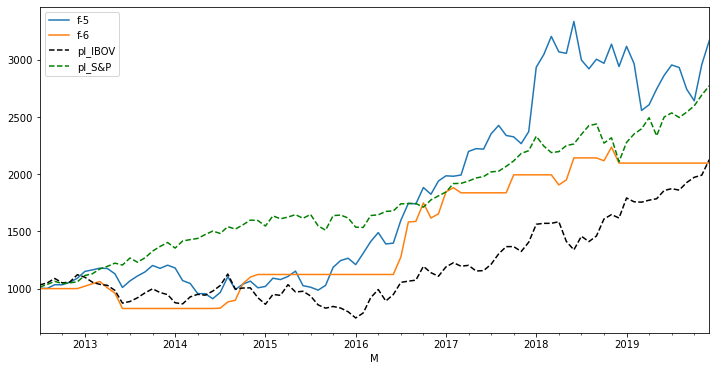

In [34]:
ax = bt_scores[['f-5', 'f-6']].plot(figsize=(12,6))
ibov_m.plot(ax=ax, style="k--")
sp_m.plot(ax=ax, style="g--")

### **F-7 : F-8**
**Conclusão.** No nosso universo de ações disponíveis para alocação não existe nehuma que tenha um F-Score maior que 7 em todo o periodo anaisado, por isso o retorno é zero.

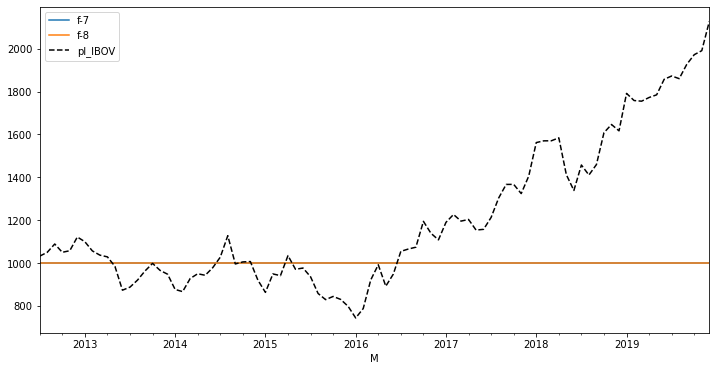

In [35]:
ax = bt_scores[['f-7', 'f-8']].plot(figsize=(12,6))
ibov_m.plot(ax=ax, style="k--")

## <font color=green|black>**3. Adicionando Taxa Livre ao variar o valor de Piotrosk:** </font>
Nessa etapa vamos analisar apenas os casos de F-5 e F-6, alocando no CDI, quando não houver nenhum ativo que atenda os requisitos mínimos de F-Score, para entender se o F-6 teria um sharpe melhor do que o F-5. E ainda vamos manter a alocação pelo método 'EW'.

**Conclusão.** Observamos que através dessa estratégia o sharpe do F-6 se aproxima bastante do F-5, porém os platos do F-6 são mais extensos do que o de F-5.

In [36]:
variacoes = []

# loop nos score min de Piotrosk 
for s in list(range(5,7)):
    melhores = x_melhores_piotroski(rets[dt_ini:], piotroski, comp_ise, minimum_score=s)
    peso_igual = ew(rets, melhores, tx_livre_risco=True)
    variacoes.append(backtest(rets[dt_ini:], peso_igual, tx_livre_risco=tx_livre)['Wealth'])

<ipython-input-20-b9bc84b1742a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rets['CDI'] = (1+tx_livre_risco)**(1/12) - 1


In [37]:
# Junta as duas possibilidades
variacoes += [ibx_m, sp_m, ibov_m]
bt_scores = reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), variacoes).copy()
bt_scores.columns = ['f-5', 'f-6', 'IBX', 'S&P','IBOV']
erk.summary_stats(bt_scores.pct_change().iloc[1:], riskfree_rate=tx_livre)[['Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown']]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
f-5,0.167564,0.216789,0.673454,-0.243061
f-6,0.118852,0.158473,0.619231,-0.221812
IBX,0.124191,0.186728,0.553583,-0.323007
S&P,0.145262,0.108716,1.141531,-0.135198
IBOV,0.102459,0.197242,0.415753,-0.340720


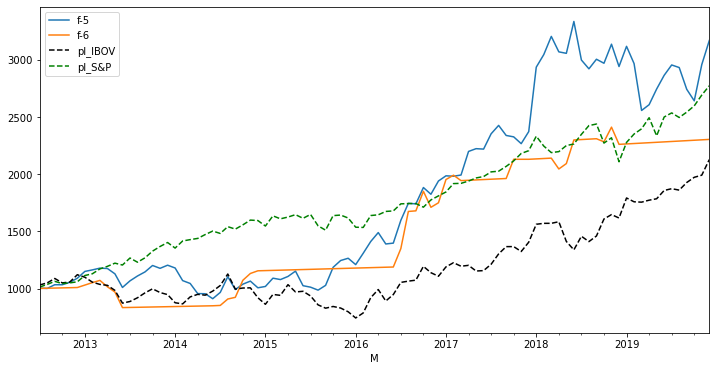

In [38]:
ax = bt_scores[['f-5', 'f-6']].plot(figsize=(12,6))
ibov_m.plot(ax=ax, style="k--")
sp_m.plot(ax=ax, style="g--")

## <font color=green|black>**4. Utilizando GMV:** </font>
Nessa etapa da análise vamos mudar o metódo de alocação para o 'GMV', e também iremos alterar os periodos possíeveis para o calculo do GMV para observar qual o impacto no EVA. No usaremos o ponto ótimo (score mínimo de 5)

**Conclusão.** Existem alguns casos em que o Sharpe do 'GMV' é maior do que o do 'EW', porém devemos lembram que o objetivo do 'GMV' é encontrar a alocação que minimiza o risco. Portanto como todos os casos tem uma vol menor que a do EW, vamos escolher o com o maior Sharpe, sendo o ponto ótimo é com 6 periodos para trás.

In [39]:
variacoes = []

# loop nos periodos de uso para o GMV 
for s in list(range(1,len(rets[:dt_ini])-1)):
    melhores = x_melhores_piotroski(rets[dt_ini:], piotroski, comp_ise, minimum_score=5)
    peso_gmv = gmv(rets, selecionados, s, dt_ini)
    variacoes.append(backtest(rets[dt_ini:], peso_gmv)['Wealth'])

c:\users\usuario\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
c:\users\usuario\appdata\local\programs\python\python38-32\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\usuario\appdata\local\programs\python\python38-32\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-16-0c18a3cdb252>:11: RuntimeWarning: invalid value encountered in double_scalars
  return (weights.T @ covmat @ weights)**0.5


In [44]:
# Junta as duas possibilidades
bt_scores = reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), variacoes).copy()
bt_scores.columns = list(range(1,len(rets[:dt_ini])-1))
sumary_gmv = erk.summary_stats(bt_scores.pct_change().iloc[1:], riskfree_rate=tx_livre)[['Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown']]
# Casos que a Vol eh menor que o do 'EW' 
sumary_gmv[sumary_gmv['Sharpe Ratio'] >= 0.673454]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
2,0.187252,0.214745,0.770007,-0.238503
4,0.173641,0.194402,0.781787,-0.275200
5,0.170496,0.178243,0.835330,-0.248252
6,0.165653,0.165970,0.868439,-0.261500
7,0.155526,0.171743,0.781269,-0.257629
9,0.134365,0.162542,0.697532,-0.267802
17,0.134759,0.167140,0.680655,-0.278397


### Todas as opções

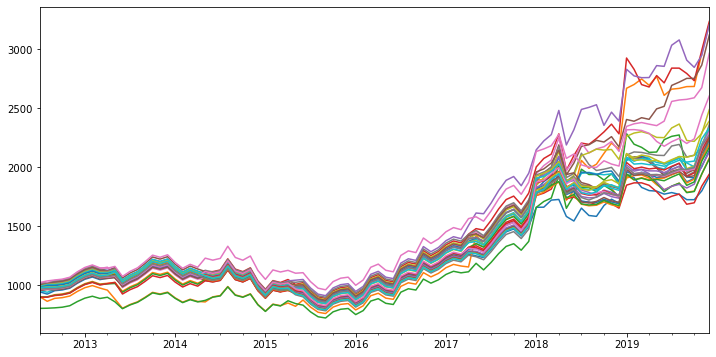

In [41]:
bt_scores.plot(figsize=(12,6), legend=False)

### Apenas as com o Sharpe Maior

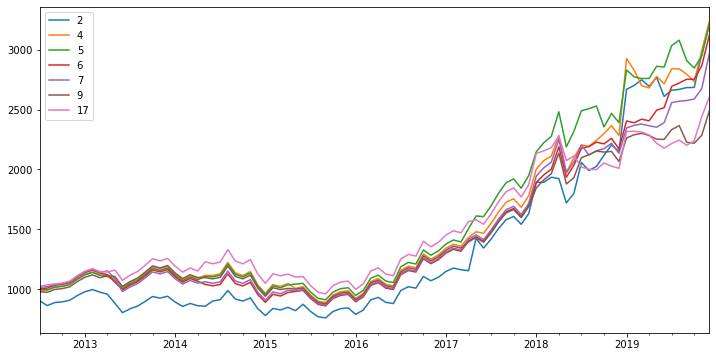

In [50]:
bt_scores[[2,4,5,6,7,9,17]].plot(figsize=(12,6))

## <font color=green|black>**5. Analise RiscoXRetorno Pornot Ótimo:** </font>
Para finalizar vamos analisar o EVA com as melhores opções encontradas, ou seja, com F-5 e GMV de 6.

In [51]:
# Backtest Melhor Opcao
f5 = x_melhores_piotroski(rets[dt_ini:], piotroski, comp_ise, minimum_score=5)
gmv6 = gmv(rets, f5, 6, dt_ini)
# portfolio otimo
portfolio_o = backtest(rets[dt_ini:], gmv6)

### **Drawdown**

**Conclusão.** A duração do drawdown máxima ainda é muito grande, sendo de aproximadamente 2 anos e meio. Fora que a quantidade de platos extanssos durante toda a estratégia é marcante, e um indício, da sua instabilidade. Além disso o drawdown máximo foi reduzido para 26%. E se comparmos com o Drawdown do S&P percebemos que o EVA possui drawdowns muio extenssos, e que sua rentabilidade se deve a alguns grandes acertos específicos. Portanto isso reforça a tese de que o EVA não é uma boa estratégia. 

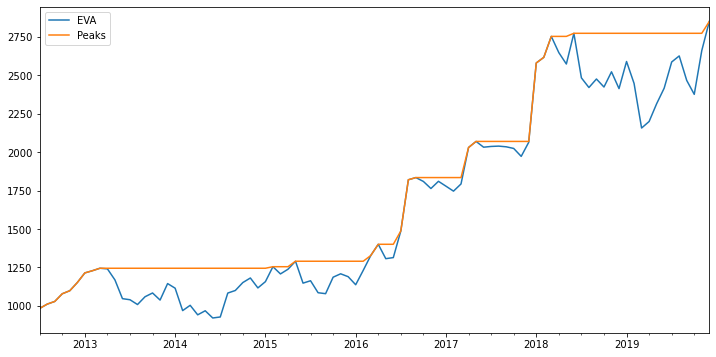

In [52]:
# Calcula e plota drawdown
drawdown = erk.drawdown(portfolio_o['Returns'])
ax_d = drawdown[['Wealth', 'Peaks']].plot(figsize=(12,6))
ax_d.legend(['EVA', 'Peaks'])

Drawdown maximo de 26.0% 



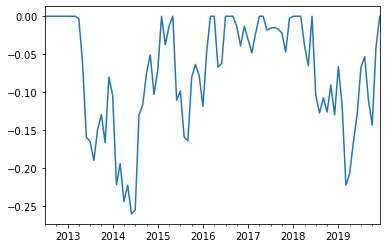

In [53]:
# Calcula Valor Drawdown
drawdown['Drawdown'].plot()
print('Drawdown maximo de {}% \n'.format(round(abs(drawdown['Drawdown'].min() * 100), 2)))

In [24]:
# tempo Maximo drawdown
"""
NNNNNNN SEI FAZER
"""

'\nNNNNNNN SEI FAZER\n'

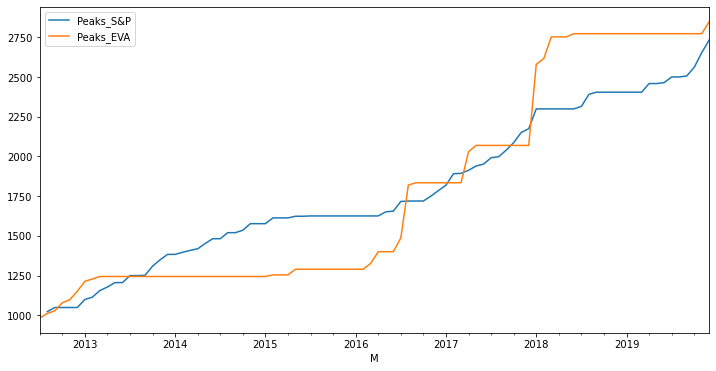

In [62]:
# Comparando Peaks EVA e S&P
comparacao_sp = erk.drawdown(sp_m['pl_S&P'].pct_change().iloc[1:])['Peaks'].plot(figsize=(12,6))
drawdown['Peaks'].plot(ax=comparacao_sp, figsize=(12,6))
comparacao_sp.legend(['Peaks_S&P','Peaks_EVA'])

### **Benchmarking**
**Conclusão.** Agora o EVA é capaz de bater tanbto o IBOV quanto o IBX em questão de Sharpe. Porém, no ano de 2018 e 2019 no qual os dois indices tiverem um crescimento vertiginoso, o EVA praticamente teve retorno negativo.

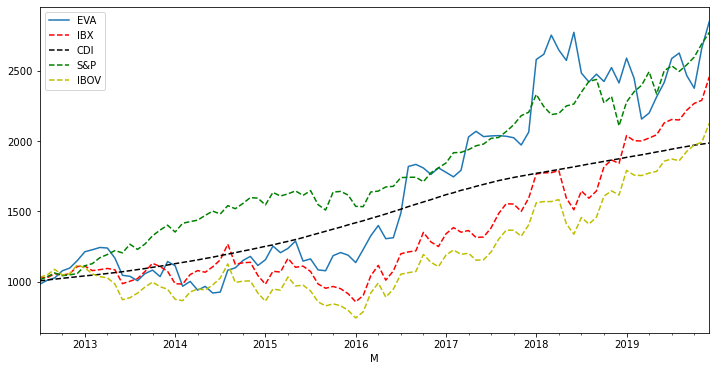

In [63]:
# Plota grafico
ax_b = drawdown['Wealth'].plot(figsize=(12,6), legend=True)
ibx_m.plot(ax=ax_b, style="r--")
cdi_m.plot(ax=ax_b, style="k--")
sp_m.plot(ax=ax_b, style="g--")
ibov_m.plot(ax=ax_b, style="y--")
ax_b.legend(['EVA', 'IBX', 'CDI', 'S&P', 'IBOV'])

In [64]:
# retorno X risco
variacoes = [drawdown['Wealth'], ibx_m, sp_m, ibov_m]
bt_scores = reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), variacoes).copy()
erk.summary_stats(bt_scores.pct_change().iloc[1:], riskfree_rate=tx_livre)[['Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown']]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Wealth,0.154344,0.228660,0.581642,-0.260018
pl_IBX,0.124191,0.186728,0.553583,-0.323007
pl_S&P,0.145262,0.108716,1.141531,-0.135198
pl_IBOV,0.102459,0.197242,0.415753,-0.340720


In [95]:
# Retorno por ano
def retorno_por_ano(port: pd.DataFrame, col: str):
    """
    :port: DataFrame com a variacao da riqueza
    :col: nome da coluna com a variacao da riqueza ao longo do periodo
    
    return DataFrame com o retorno por ano
    """
    port['A'] = port.index.asfreq('Y')
    fin = port.groupby('A').last()[col].copy()
    ini = port.groupby('A').first()[col].copy()
    return pd.DataFrame((fin - ini) / ini)

In [106]:
# Calcula o retorno de cada ano
rets_por_ano = [retorno_por_ano(df.copy(), df.columns[0]) for df in [portfolio_o, ibx_m, sp_m, ibov_m]]

bech_ano = reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), rets_por_ano).copy()
bech_ano.columns = ['EVA', 'IBX', 'S&P', 'IBOV']
bech_ano

,EVA,IBX,S&P,IBOV
A,,,,
2012,0.171166,0.076038,0.044988,0.086546
2013,-0.057179,-0.033504,0.258690,-0.138121
2014,0.001578,0.058433,0.177600,0.049716
2015,0.027918,-0.069361,0.045215,-0.075845
2016,0.591944,0.458162,0.178058,0.490553
2017,0.160687,0.189695,0.195639,0.181400
2018,-0.064664,0.042227,-0.095621,0.035031
2019,0.100596,0.204810,0.217314,0.187400


### **CPPI**

**Conclusão.** Diferente do primeiro caso o CPPI, não parece ser uma boa estratégia de insurance nesse caso, uma vez que o retorno da estratégia é devido a grandes picos específicos. Por isso o CPPI diminui muito o retorno desses grandes picos se comparado com a diminuição do risco.

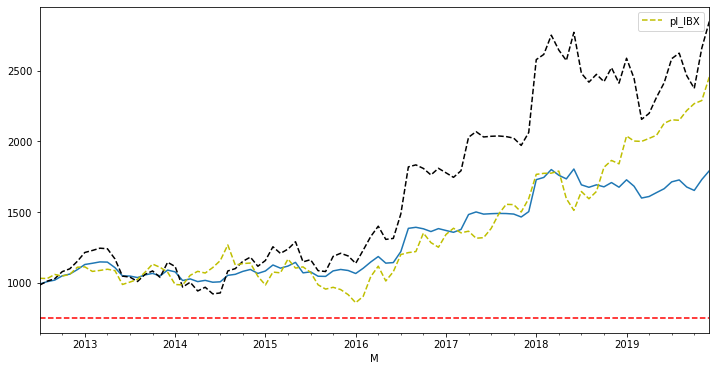

In [114]:
cppi = erk.run_cppi(portfolio_o['Returns'], drawdown = 0.2, riskfree_rate=tx_livre)
ax = cppi['Wealth'].plot(figsize=(12,6), legend=False)
cppi["Risky Wealth"].plot(ax=ax, style="k--", legend=False)
ibx_m.plot(ax=ax, style="y--")
ax.axhline(y=750, color='r', linestyle="--")

In [107]:
# retorno X risco
variacoes = [cppi["Risky Wealth"], cppi['Wealth']]
bt_scores = reduce(lambda x, y: pd.merge(x, y, how='left', left_index=True, right_index=True), variacoes).copy()
erk.summary_stats(bt_scores.pct_change().iloc[1:], riskfree_rate=tx_livre)[['Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown']]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Returns_x,0.154344,0.228660,0.581642,-0.260018
Returns_y,0.083297,0.116814,0.540945,-0.125475


### **Retorno**

**Conclusão.** Fomos capazes de aumentar o retorno do EVA. Porém não se pode inferir muito com apenas o retorno. Além disso, sabemos que o sharpe da estratégia ainda é menor do que 1, indicando que a estrégia tem um baixo retorno se comprado ao quantidade de risco proporcionada.

In [116]:
# Retorno Total do periodo
r_total_o = ((portfolio_o['Returns']+1).prod()-1)
print('Retorno Total: {}%'.format(round(r_total_o*100, 2)))

# Retorno por periodos
## Anualizado
r_anualizado_o = ((r_total_o + 1) ** (12/len(portfolio_o)) - 1) * 100
print('Retorno Anualizado: {}%'.format(round(r_anualizado_o, 2)))
## Mensal
r_mensal_o = ((r_total_o + 1) ** (1/len(portfolio_o)) - 1) * 100
print('Retorno Mensal: {}%'.format(round(r_mensal_o, 2)))

Retorno Total: 185.02%
Retorno Anualizado: 14.99%
Retorno Mensal: 1.17%


### **Diverssificação**

**Conclusão.** Existem periodos que a estratégia aloca em apenas um unico ativo, o que talvez não seja muito bom se formos pensar em relação a questão de diversidade

In [125]:
# Numero de ativos alocados por periodo
portfolio_o['N_ativo'] = n_ativos = [len(f5[key]) for key in f5]
portfolio_o

,Wealth,Returns,A,N_ativo
2012-07,983.012189,-0.016988,2012,5
2012-08,1010.949923,0.028421,2012,5
2012-09,1028.252922,0.017116,2012,5
2012-10,1078.335109,0.048706,2012,5
2012-11,1098.154773,0.018380,2012,5
...,...,...,...,...
2019-08,2625.860450,0.015199,2019,7
2019-09,2466.511035,-0.060685,2019,7
2019-10,2375.957543,-0.036713,2019,1
2019-11,2660.697757,0.119842,2019,1


<div align='center'><a href='https://www.facebook.com/fea.dev/'/ style='display:inline-block'>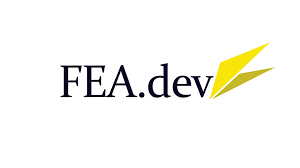<a/><div/>